In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import ltspice
import subprocess
import pickle
import os

In [2]:
# loading parameters
# Read the variables from the file
with open("Model\\parameters.pkl", "rb") as file:
    data = pickle.load(file)

# Access variables from the dictionary
n = data["n"]
m = data["m"]
I = data["I"]
RF_finger = data["RF_finger"]
RB_finger = data["RB_finger"]
RG_finger = data["RG_finger"]
RF_busbar = data["RF_busbar"]
RB_busbar = data["RB_busbar"]
RG_busbar = data["RG_busbar"]
Rshunt = data["Rshunt"]
Rseries = data["Rseries"]
Rpogo = data["RPogo_pin"]

In [3]:
#probing coordinates
def divide_into_segments(m, segments=10):
    points = []
    for i in range(1, segments):
        points.append(i * m // segments)
    return points


#probing coordinates
# V_Probe_bottom = [(60,5)]
# V_Probe_bottom = [(59,5)]
V_Probe_bottom_drill = [(60,5)]
V_Probe_bottom = [(60,5)]

# I_Probe_bottom = [(120,5)]
I_Probe_bottom = [(119,5)]

print("V_Probe_bottom:", V_Probe_bottom)
print("I_Probes_bottom:", I_Probe_bottom)

points = divide_into_segments(m)
print("Points: ",points)

num_probes_per_busbar = len(divide_into_segments(m))
print('num_probes_per_busbar: ',num_probes_per_busbar)

V_finger_idx_top = points[int((num_probes_per_busbar+1)/2) - 1]

V_Probe_top = []
I_Probe_top = []
# Generate the probe points for each column
for bb_id in range(1,n+1):
    for f_id in range(1,m+1):
        if f_id in points:
            # I_Probe_top.append((f_id-5,bb_id))
            # V_Probe_top.append((f_id,bb_id))
            # I_Probe_top.append((f_id+5,bb_id))
            if f_id == V_finger_idx_top:
                V_Probe_top.append((f_id,bb_id))
            else:
                I_Probe_top.append((f_id,bb_id))            

# Display the result
print("V_Probe_top:", V_Probe_top)
print("I_Probe_top:", I_Probe_top)

V_Probe_bottom: [(60, 5)]
I_Probes_bottom: [(119, 5)]
Points:  [12, 24, 36, 48, 60, 72, 84, 96, 108]
num_probes_per_busbar:  9
V_Probe_top: [(60, 1), (60, 2), (60, 3), (60, 4), (60, 5), (60, 6), (60, 7), (60, 8), (60, 9)]
I_Probe_top: [(12, 1), (24, 1), (36, 1), (48, 1), (72, 1), (84, 1), (96, 1), (108, 1), (12, 2), (24, 2), (36, 2), (48, 2), (72, 2), (84, 2), (96, 2), (108, 2), (12, 3), (24, 3), (36, 3), (48, 3), (72, 3), (84, 3), (96, 3), (108, 3), (12, 4), (24, 4), (36, 4), (48, 4), (72, 4), (84, 4), (96, 4), (108, 4), (12, 5), (24, 5), (36, 5), (48, 5), (72, 5), (84, 5), (96, 5), (108, 5), (12, 6), (24, 6), (36, 6), (48, 6), (72, 6), (84, 6), (96, 6), (108, 6), (12, 7), (24, 7), (36, 7), (48, 7), (72, 7), (84, 7), (96, 7), (108, 7), (12, 8), (24, 8), (36, 8), (48, 8), (72, 8), (84, 8), (96, 8), (108, 8), (12, 9), (24, 9), (36, 9), (48, 9), (72, 9), (84, 9), (96, 9), (108, 9)]


In [4]:
#make a log file for this simulation set (change this file name for each directory)
# folder_name = "sim1"
file_path = "Model\\sim1\\configI\\"
net_name = "solarcell"

creating the top, finite elements and bottom grid

In [5]:
def generate_rg_f_remove(V_Probe_bottom):
    RG_f_remove = []
    
    for i, j in V_Probe_bottom:
        if (i, j-1) not in RG_f_remove:
            RG_f_remove.append((i, j-1))
        if (i, j) not in RG_f_remove:
            RG_f_remove.append((i, j))
    RG_f_remove.sort()
    
    return RG_f_remove

def generate_rg_b_remove(V_Probe_bottom):
    RG_b_remove = []
    
    for i, j in V_Probe_bottom:
        if (i-1, j) not in RG_b_remove:
            RG_b_remove.append((i-1, j))
        if (i, j) not in RG_b_remove:
            RG_b_remove.append((i, j))
    RG_b_remove.sort()
    
    return RG_b_remove

RG_f_remove = generate_rg_f_remove(V_Probe_bottom_drill)
RG_b_remove = generate_rg_b_remove(V_Probe_bottom_drill)

In [6]:
def netlist_solar_cell_fin_ele(Rsh, Rsr, I, indx, indy):
    netlist =f"""
I{indx}_{indy} T{indx}_{indy} N{indx}_{indy} {I}
D{indx}_{indy} N{indx}_{indy} T{indx}_{indy} D
Rshunt{indx}_{indy} N{indx}_{indy} T{indx}_{indy} {Rsh}
Rseries{indx}_{indy} G{indx}_{indy} N{indx}_{indy} {Rsr} 
"""
    return netlist

def netlist_solar_cell_top_ele(R_fingers, R_bb, n, m):
    netlist = ""
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RF_f{i}_{j} T{i}_{j} T{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line

    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RF_b{i}_{j} T{i}_{j} T{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_solar_cell_bottom_ele(R_fingers, R_bb, n, m):
    netlist = ""
    for i in range(0, m+2):
        for j in range(0, n+2):
            if i >= 1 and i <= m:
                if j <= n:
                    line = f"RB_f{i}_{j} G{i}_{j} G{i}_{j+1} {R_fingers[i-1][j]}\n"
                    netlist += line
                    
    for j in range(0, n+2):
        for i in range(0, m+2):
            if j >= 1 and j <= n:
                if i <= m:
                    line = f"RB_b{i}_{j} G{i}_{j} G{i+1}_{j} {R_bb[i][j-1]}\n"
                    netlist += line
    return netlist


def netlist_gold_chuck_ele(R_fingers, R_bb, n, m, RG_f_remove, RG_b_remove):
    netlist = ""
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RG_f{i}_{j} G{i}_{j} G{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line

    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RG_b{i}_{j} G{i}_{j} G{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line

    for (i, j) in RG_f_remove:
        line_to_remove = f"RG_f{i}_{j} G{i}_{j} G{i}_{j+1} "
        netlist = '\n'.join([line for line in netlist.split('\n') if not line.startswith(line_to_remove)])

    for (i, j) in RG_b_remove:
        line_to_remove = f"RG_b{i}_{j} G{i}_{j} G{i+1}_{j} "
        netlist = '\n'.join([line for line in netlist.split('\n') if not line.startswith(line_to_remove)])    
    return netlist


# def netlist_V_source():
#     # netlist = f"V1 Vpos 0 DC 0\n"
#     netlist = f"I1 IB 0 DC 0\n"
#     # netlist = f"V1 VB VF DC 0\n"
#     return netlist

# def netlist_simtype():
#     netlist = ".dc I1 0 12 0.01\n"
#     return netlist

In [7]:
def solar_cell_netlist():

    # Initialize the netlist with the header
    netlist = """*C:\\Users\\ASUS\\Desktop\\Semesters\\Sem 8\\BTP\\Simulation\\FEM_Mk7\\Model\\sim1\\configI"""
    netlist += file_path
    netlist += net_name + '.asc\n'
    
    # top resistance grid
    # nodes from T00 to Tnn
    netlist += netlist_solar_cell_top_ele(RF_finger, RF_busbar, n, m)

    # finite element
    for i in range(1,m+1):
        for j in range(1,n+1):
            netlist += netlist_solar_cell_fin_ele(Rshunt[i-1][j-1], Rseries[i-1][j-1], I, i, j)
    
    # bottom resistance grid
    # nodes from B00 to Bnn
    netlist += netlist_solar_cell_bottom_ele(RB_finger, RB_busbar, n, m)

    # chuck resistance grid
    # nodes from G00 to Gnn
    netlist += netlist_gold_chuck_ele(RG_finger, RG_busbar, n, m, RG_f_remove, RG_b_remove)

    # adding the voltage source
    ###############################################
    # netlist += netlist_V_source()

    for (x,y) in I_Probe_bottom:
        # netlist = netlist.replace(f" B{x}_{y}", " Vpos")
        netlist += f"RpogoB{x}_{y} G{x}_{y} IB {Rpogo}\n"

    for (x,y) in V_Probe_bottom:
        # netlist = netlist.replace(f" B{x}_{y}", " Vpos")
        netlist += f"RpogoB{x}_{y} G{x}_{y} VB {Rpogo}\n"
    

    for (x,y) in I_Probe_top:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
        #  netlist += f"RpogoT{x}_{y} T{x}_{y} IF {Rpogo}\n"
         netlist += f"RpogoT{x}_{y} T{x}_{y} IF {Rpogo}\n"

    for (x,y) in V_Probe_top:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
        #  netlist += f"RpogoT{x}_{y} T{x}_{y} VF {Rpogo}\n"
         netlist += f"RpogoT{x}_{y} T{x}_{y} VF {Rpogo}\n"

    # # adding the simulation type
    ###############################################
    # netlist += netlist_simtype()

    # Add the footer
    netlist += """.model D D
.lib C:\\Users\\ASUS\\AppData\\Local\\LTspice\\lib\\cmp\\standard.dio
.backanno
.end"""

    return netlist


output_file = file_path + net_name +'.net'
with open(output_file, 'w') as file:
    file.write(solar_cell_netlist())

In [8]:
# Define the directory path where both files will be located
directory_path = r"C:\Users\ASUS\Desktop\Semesters\Sem 8\BTP\Simulation\FEM_Mk7_ForSpiceCheck\Model\sim1\configI"

# Define file paths using the directory
netlist_file = os.path.join(directory_path, "solarcell.net")
subckt_file = os.path.join(directory_path, "solarcell.sub")

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"Error: The directory does not exist: {directory_path}")
else:
    print(f"Directory exists: {directory_path}")

# Check if the netlist file exists
if not os.path.exists(netlist_file):
    print(f"Error: The file does not exist: {netlist_file}")
else:
    print(f"File found: {netlist_file}")

# Read the netlist file if it exists
if os.path.exists(netlist_file):
    with open(netlist_file, 'r') as f:
        netlist_lines = f.readlines()

    # Create the .sub file with new first and last lines
    with open(subckt_file, 'w') as f:
        # Add the first line for the .sub file
        f.write(".SUBCKT solarcell IF IB VF VB\n")
        
        # Copy all lines from the original netlist file except for the last line
        for line in netlist_lines:
            if ".end" not in line:  # Skip the .dc line
                f.write(line)
        
        # Replace the last line with ".ENDS solarcell"
        f.write(".ENDS solarcell\n")

    print(f"solarcell.sub file created successfully at: {subckt_file}")

Directory exists: C:\Users\ASUS\Desktop\Semesters\Sem 8\BTP\Simulation\FEM_Mk7_ForSpiceCheck\Model\sim1\configI
File found: C:\Users\ASUS\Desktop\Semesters\Sem 8\BTP\Simulation\FEM_Mk7_ForSpiceCheck\Model\sim1\configI\solarcell.net
solarcell.sub file created successfully at: C:\Users\ASUS\Desktop\Semesters\Sem 8\BTP\Simulation\FEM_Mk7_ForSpiceCheck\Model\sim1\configI\solarcell.sub


now i have the netlist ready lets try simulating it!

In [9]:
# # Path to LTSpice executable
# ltspice_exe = 'C:\\Program Files\\ADI\\LTspice\\LTspice.exe'

# def RunLTsimulation(netlist_file):
#     # Run LTSpice simulation
#     subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

# # Path to the netlist file
# netlist_file = output_file 

# #running simulation
# RunLTsimulation(netlist_file)

# # Extract data
# # Load the LTSpice data
# lt = ltspice.Ltspice(file_path + net_name +'.raw')
# lt.parse()

In [10]:
# I = lt.get_data("i1")
# # Vmeas = lt.get_data("V(vb)") - lt.get_data("V(vf)")
# V = lt.get_data("V(vb)") - lt.get_data("V(vf)")

# zero_crossing_index = np.argmax(I <= 0)  # First index where I <= 0

# # Slice the data up to the zero-crossing point
# # V_trimmed = V[:zero_crossing_index]
# # I_trimmed = I[:zero_crossing_index]
# # Vmeas_trimmed = Vmeas[:zero_crossing_index]

# I_trimmed = I
# V_trimmed = V


# # plt.figure(figsize=[18, 6])

# # plt.subplot(1, 3, 1)
# # plt.plot(V_trimmed, I_trimmed,"--o")
# # plt.xlabel("Voltage (V)")
# # plt.ylabel("Current (I)")
# # plt.title("V vs I")

# # plt.subplot(1, 3, 2)
# # plt.plot(Vmeas_trimmed, I_trimmed,"--o")
# # plt.xlabel("Measured Voltage (Vmeas)")
# # plt.ylabel("Current (I)")
# # plt.title("Vmeas vs I")

# # plt.subplot(1,3,3)
# # plt.plot(V_trimmed, I_trimmed,"--o", label = "Imposed V")
# # plt.plot(Vmeas_trimmed, I_trimmed,"--o", label = "Measured V")
# # plt.xlabel("Voltage (in V)")
# # plt.ylabel("Current(I)")
# # plt.title("Comparing V and Vmeas")
# # plt.legend()

# # # Show the plots
# # plt.tight_layout()
# # plt.show()


# plt.figure(figsize=[8,8])

# plt.plot(V_trimmed,I_trimmed,"--o")
# plt.xlabel("Voltage (in V)")
# plt.ylabel("Current (in A)")
# plt.title("IV characteristic for Non isolated back contact using current sweep")
# plt.xlim([0,0.8])
# plt.show()

In [11]:
# # Voltage distribution on each finite element
# VB_grid = []
# VF_grid = []
# I_grid = []

# for i in range(1, m+1):
#     for j in range(1, n+1):
#         VF_grid.append(lt.get_data(f"V(t{i}_{j})"))
#         VB_grid.append(lt.get_data(f"V(g{i}_{j})"))
#         I_grid.append(lt.get_data(f"I(Rseries{i}_{j})"))

# sz = len(I_grid[0])
# I_grid = np.array(I_grid).reshape(m, n, sz)
# VF_grid = np.array(VF_grid).reshape(m, n, sz)
# VB_grid = np.array(VB_grid).reshape(m, n, sz)

In [12]:
I_Probe_top1 = [(x-1, y-1) for x, y in I_Probe_top]
V_Probe_top1 = [(x-1, y-1) for x, y in V_Probe_top]
I_Probe_bottom1 = [(x-1, y-1) for x, y in I_Probe_bottom]
V_Probe_bottom1 = [(x-1, y-1) for x, y in V_Probe_bottom]
V_Probe_bottom_drill1 = [(x-1, y-1) for x, y in V_Probe_bottom_drill]

# Extract x, y positions for probes
I_Probe_top_x, I_Probe_top_y = zip(*I_Probe_top1)
V_Probe_top_x, V_Probe_top_y = zip(*V_Probe_top1)
I_Probe_bottom_x, I_Probe_bottom_y = zip(*I_Probe_bottom1)
V_Probe_bottom_x, V_Probe_bottom_y = zip(*V_Probe_bottom1)

V_Probe_bottom_drill_x, V_Probe_bottom_drill_y = zip(*V_Probe_bottom_drill1)


In [13]:
# # Choose the slice index to visualize
# slice_index = 45

# # Calculate operating point (example: using the mean values at the slice index)
# V_op = np.mean(V[slice_index])
# I_op = np.mean(I[slice_index])


# # Display the images
# plt.figure(figsize=[24, 8])

# # Forward Voltage (VF) plane
# plt.subplot(1, 3, 1)
# plt.scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='F_probes', s=100, marker='x')
# plt.scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=100, marker='^')
# plt.imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
# plt.colorbar(label='Voltage (V)')
# plt.title('Voltage Distribution Top(VT)')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()

# # Current (I) plane
# plt.subplot(1, 3, 2)
# plt.scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
# plt.scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
# plt.scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Probe_Neg', s=50, marker='x')
# plt.scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=50, marker='^')

# plt.imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
# plt.colorbar(label='Current (A)')
# plt.title('Current Through series resistor (Iser)')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()

# # Back Voltage (VB) plane
# plt.subplot(1, 3, 3)
# plt.scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
# plt.scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
# plt.imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
# plt.colorbar(label='Voltage (V)')
# plt.title('Voltage Distribution Bottom(VB)')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.savefig("fin_sim_fr.pdf")
# plt.tight_layout()
# plt.show()

# # Plot IV characteristic curve
# plt.figure(figsize=[10, 5])
# plt.plot(V_trimmed,I_trimmed, label='IV Characteristic')
# plt.scatter(V_op, I_op, color='red', label=f'Operating Point: V={V_op:.2f}, I={I_op:.2f}')
# plt.xlabel('Voltage (V)')
# plt.ylabel('Current (A)')
# plt.title('IV Characteristic Curve')
# plt.legend()
# plt.grid(True)
# plt.savefig("fin_sim_IV.pdf")
# plt.show()

In [14]:
# # List of slice indices
# slice_indices = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# # Set up the figure and subplots (17x3 grid)
# fig, axes = plt.subplots(17, 3, figsize=[24, 126])

# # Loop through the slice indices and plot in each subplot
# for idx, slice_index in enumerate(slice_indices):
#     row = idx  # Row index (corresponds to slice_index)
    
#     # Forward Voltage (VF) plane
#     axes[row, 0].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='F_probes', s=100, marker='x')
#     axes[row, 0].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=100, marker='^')
#     im1 = axes[row, 0].imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
#     axes[row, 0].set_title(f'Voltage Distribution Top(VT) Slice {slice_index}')
#     axes[row, 0].set_xlabel('X-axis')
#     axes[row, 0].set_ylabel('Y-axis')
#     axes[row, 0].legend()
#     fig.colorbar(im1, ax=axes[row, 0], label='Voltage (V)')
    
#     # Current (I) plane
#     axes[row, 1].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
#     axes[row, 1].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
#     axes[row, 1].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Probe_Neg', s=50, marker='x')
#     axes[row, 1].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='V_probes', s=50, marker='^')
#     im2 = axes[row, 1].imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
#     axes[row, 1].set_title(f'Current Through Series Resistor (Iser) Slice {slice_index}')
#     axes[row, 1].set_xlabel('X-axis')
#     axes[row, 1].set_ylabel('Y-axis')
#     axes[row, 1].legend()
#     fig.colorbar(im2, ax=axes[row, 1], label='Current (A)')
    
#     # Back Voltage (VB) plane
#     axes[row, 2].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
#     axes[row, 2].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
#     im3 = axes[row, 2].imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
#     axes[row, 2].set_title(f'Voltage Distribution Bottom(VB) Slice {slice_index}')
#     axes[row, 2].set_xlabel('X-axis')
#     axes[row, 2].set_ylabel('Y-axis')
#     axes[row, 2].legend()
#     fig.colorbar(im3, ax=axes[row, 2], label='Voltage (V)')

# # Adjust layout for better spacing
# plt.tight_layout()

# # Save the figure as a PDF
# plt.savefig("fin_sim_all_slices.pdf")

# # Show the plot
# plt.show()

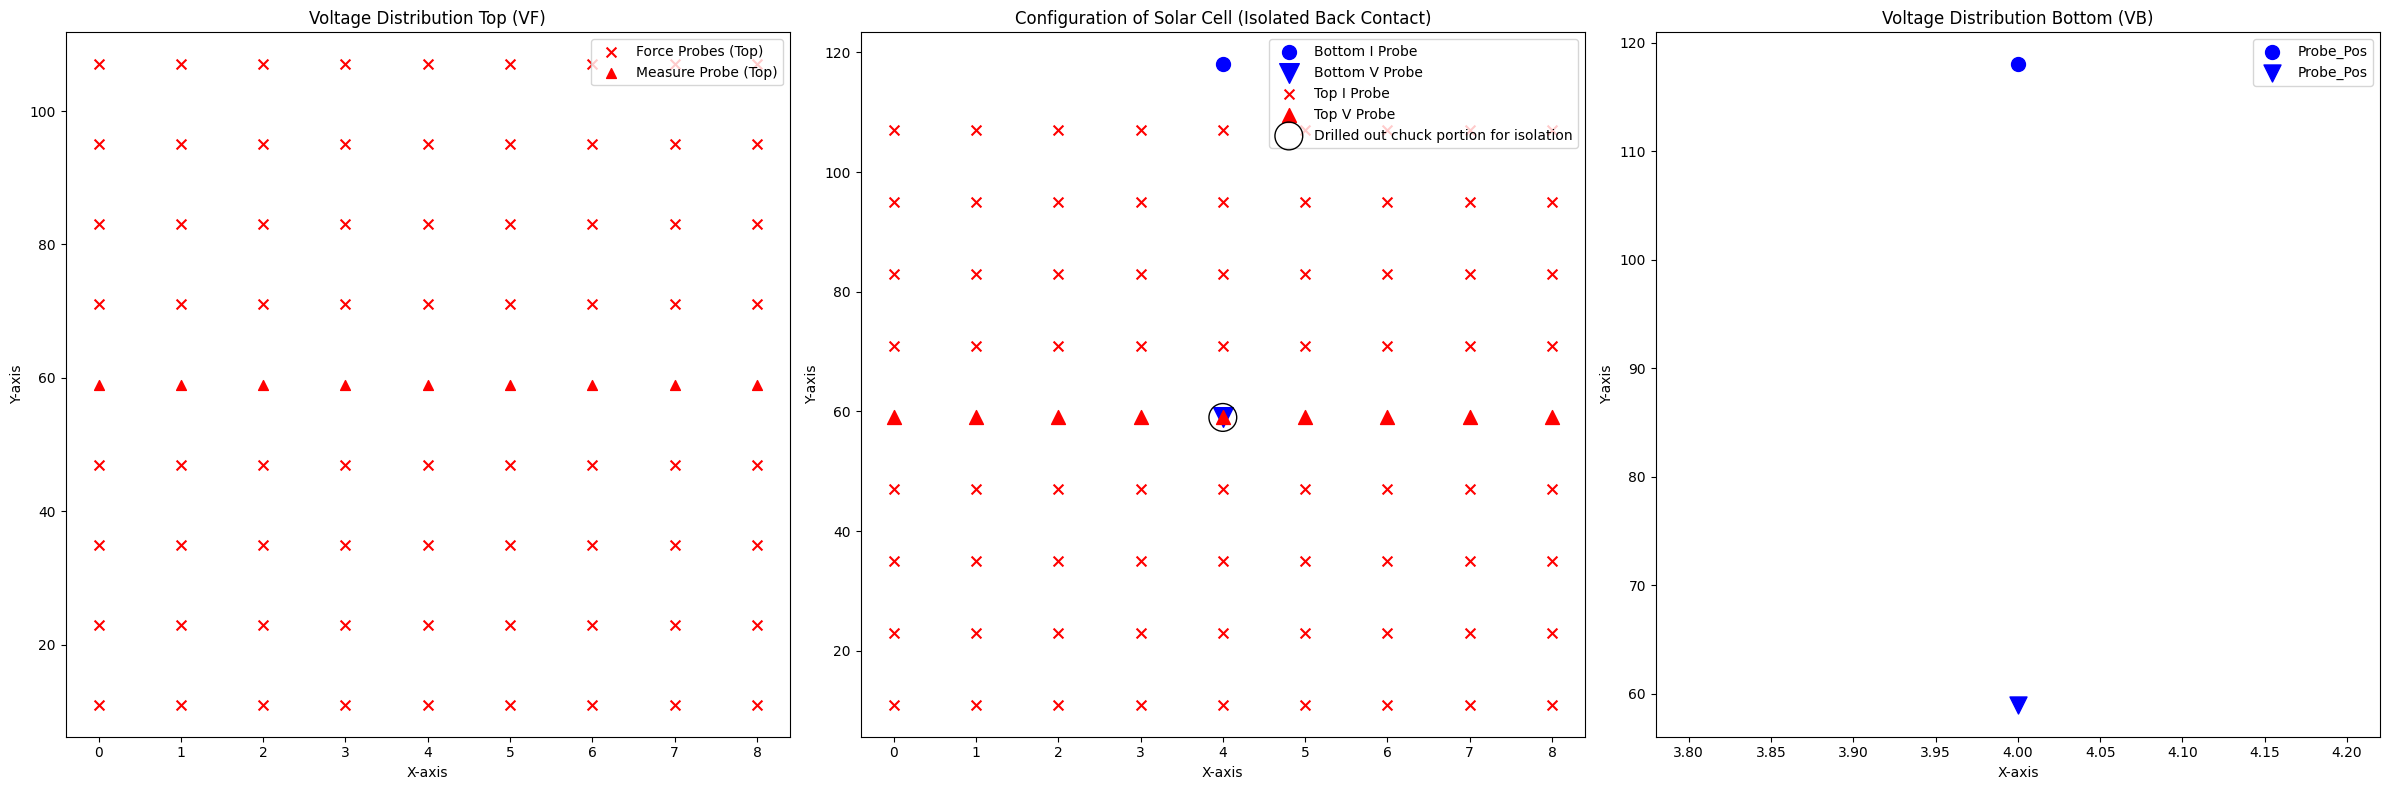

In [15]:
# Define color scale range for the selected plots (VF, I, and VB)
# vmin_vf, vmax_vf = VF_grid.min(), VF_grid.max()  # Range for VF
# vmin_i, vmax_i = I_grid.min(), I_grid.max()     # Range for I
# vmin_vb, vmax_vb = VB_grid.min(), VB_grid.max() # Range for VB

# Initialize the figure for three subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Create the initial plots for each subplot (same as the code you provided)

# Voltage (VF) plane
# ax[0].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe (Bottom)', s=100, marker='o')
ax[0].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Force Probes (Top)', s=50, marker='x')
ax[0].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='Measure Probe (Top)', s=50, marker='^')
# im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vf, vmax=vmax_vf)
# im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_vf, ax=ax[0], label="Voltage (V)")
ax[0].set_title("Voltage Distribution Top (VF)")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")
ax[0].legend()

# Current (I) plane
ax[1].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Bottom I Probe', s=100, marker='o')
ax[1].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Bottom V Probe', s=200, marker='v')
ax[1].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Top I Probe', s=50, marker='x')
ax[1].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='Top V Probe', s=100, marker='^')
# ax[1].scatter(V_Probe_bottom_drill_y,V_Probe_bottom_drill_x,color='green', label='Drilled out chuck portion for isolation', s = 80, marker='o')
ax[1].scatter(V_Probe_bottom_drill_y, V_Probe_bottom_drill_x,
           color='green', label='Drilled out chuck portion for isolation',
           s=400, marker='o', facecolors='none', edgecolors='black')
# im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_i, vmax=vmax_i)
# im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_i, ax=ax[1], label="Current (A)")
ax[1].set_title("Configuration of Solar Cell (Isolated Back Contact)")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")
ax[1].legend()

# Back Voltage (VB) plane
ax[2].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
ax[2].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
# im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vb, vmax=vmax_vb)
# im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_vb, ax=ax[2], label="Voltage (V)")
ax[2].set_title("Voltage Distribution Bottom (VB)")
ax[2].set_xlabel("X-axis")
ax[2].set_ylabel("Y-axis")
ax[2].legend()

plt.tight_layout()

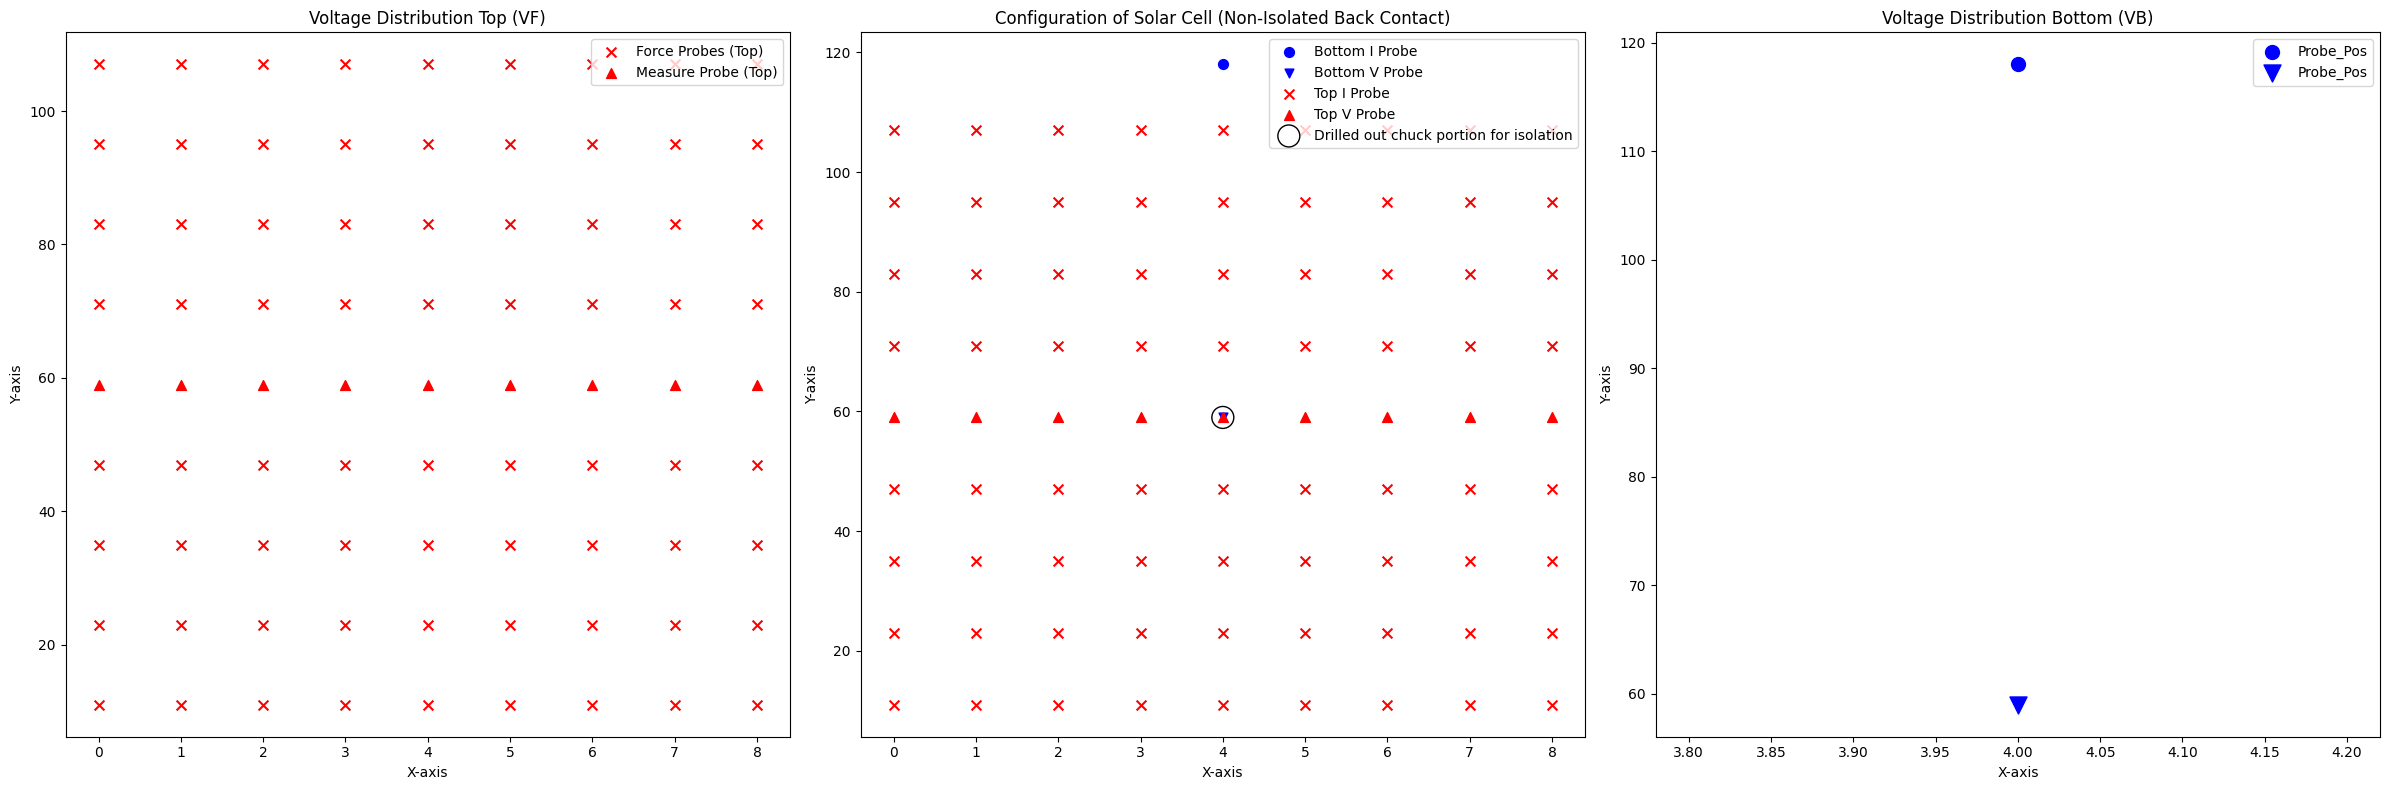

In [16]:
# Define color scale range for the selected plots (VF, I, and VB)
# vmin_vf, vmax_vf = VF_grid.min(), VF_grid.max()  # Range for VF
# vmin_i, vmax_i = I_grid.min(), I_grid.max()     # Range for I
# vmin_vb, vmax_vb = VB_grid.min(), VB_grid.max() # Range for VB

# Initialize the figure for three subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Create the initial plots for each subplot (same as the code you provided)

# Voltage (VF) plane
# ax[0].scatter(Probe_bottom_y, Probe_bottom_x, color='blue', label='Probe (Bottom)', s=100, marker='o')
ax[0].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Force Probes (Top)', s=50, marker='x')
ax[0].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='Measure Probe (Top)', s=50, marker='^')
# im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vf, vmax=vmax_vf)
# im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_vf, ax=ax[0], label="Voltage (V)")
ax[0].set_title("Voltage Distribution Top (VF)")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")
ax[0].legend()

# Current (I) plane
ax[1].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Bottom I Probe', s=50, marker='o')
ax[1].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Bottom V Probe', s=40, marker='v')
ax[1].scatter(I_Probe_top_y, I_Probe_top_x, color='red', label='Top I Probe', s=50, marker='x')
ax[1].scatter(V_Probe_top_y, V_Probe_top_x, color='red', label='Top V Probe', s=50, marker='^')
# ax[1].scatter(V_Probe_bottom_drill_y,V_Probe_bottom_drill_x,color='green', label='Drilled out chuck portion for isolation', s = 80, marker='o')
ax[1].scatter(V_Probe_bottom_drill_y, V_Probe_bottom_drill_x,
           color='green', label='Drilled out chuck portion for isolation',
           s=250, marker='o', facecolors='none', edgecolors='black')
# im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_i, vmax=vmax_i)
# im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_i, ax=ax[1], label="Current (A)")
ax[1].set_title("Configuration of Solar Cell (Non-Isolated Back Contact)")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")
ax[1].legend()

# Back Voltage (VB) plane
ax[2].scatter(I_Probe_bottom_y, I_Probe_bottom_x, color='blue', label='Probe_Pos', s=100, marker='o')
ax[2].scatter(V_Probe_bottom_y, V_Probe_bottom_x, color='blue', label='Probe_Pos', s=150, marker='v')
# im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vb, vmax=vmax_vb)
# im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot")
# fig.colorbar(im_vb, ax=ax[2], label="Voltage (V)")
ax[2].set_title("Voltage Distribution Bottom (VB)")
ax[2].set_xlabel("X-axis")
ax[2].set_ylabel("Y-axis")
ax[2].legend()

plt.tight_layout()



In [17]:
# # Animation update function
# def update(slice_index):
#     # Update each subplot with the current slice index
#     im_vf.set_array(VF_grid[:, :, slice_index])  # Update VF grid for the current slice index
#     im_i.set_array(I_grid[:, :, slice_index])    # Update I grid for the current slice index
#     im_vb.set_array(VB_grid[:, :, slice_index])  # Update VB grid for the current slice index
#     return [im_vf, im_i, im_vb]  # Return all updated images

# # Create the animation
# anim = FuncAnimation(fig, update, frames=range(0, 81), interval=200, blit=True)

# # Save the animation as a GIF
# gif_writer = PillowWriter(fps=5)  # Adjust FPS for speed
# anim.save("voltage_current_back_voltage.gif", writer=gif_writer)

# print("GIF saved as 'voltage_current_back_voltage.gif'")